In [3]:
import pandas as pd
from statsbombpy import sb
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter

from mplsoccer import Pitch, VerticalPitch, FontManager, Sbopen

In [4]:
sb.competitions()

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,9,27,Germany,1. Bundesliga,male,False,False,2015/2016,2023-12-12T07:43:33.436182,None,None,2023-12-12T07:43:33.436182
1,1267,107,Africa,African Cup of Nations,male,False,True,2023,2024-02-14T05:41:27.566989,None,None,2024-02-14T05:41:27.566989
2,16,4,Europe,Champions League,male,False,False,2018/2019,2023-03-07T12:20:48.118250,2021-06-13T16:17:31.694,None,2023-03-07T12:20:48.118250
3,16,1,Europe,Champions League,male,False,False,2017/2018,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2021-01-23T21:55:30.425330
4,16,2,Europe,Champions League,male,False,False,2016/2017,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2020-07-29T05:00
...,...,...,...,...,...,...,...,...,...,...,...,...
66,55,43,Europe,UEFA Euro,male,False,True,2020,2023-02-24T21:26:47.128979,2023-04-27T22:38:34.970148,2023-04-27T22:38:34.970148,2023-02-24T21:26:47.128979
67,35,75,Europe,UEFA Europa League,male,False,False,1988/1989,2023-06-18T19:28:39.443883,2021-06-13T16:17:31.694,None,2023-06-18T19:28:39.443883
68,53,106,Europe,UEFA Women's Euro,female,False,True,2022,2023-10-24T03:36:54.066267,2023-10-24T03:37:29.085948,2023-10-24T03:37:29.085948,2023-10-24T03:36:54.066267
69,72,107,International,Women's World Cup,female,False,True,2023,2023-12-12T14:06:50.626363,2023-12-12T14:12:41.561162,2023-12-12T14:12:41.561162,2023-12-12T14:06:50.626363


In [5]:
sb.matches(competition_id=43, season_id=106).match_id

0     3857256
1     3869151
2     3857257
3     3857258
4     3857288
       ...   
59    3857265
60    3857262
61    3857261
62    3857255
63    3857254
Name: match_id, Length: 64, dtype: int64

In [6]:
matches = sb.matches(competition_id=43, season_id=106)

In [7]:
match_ids = matches['match_id'].tolist()

In [32]:
def fetch_and_filter_goals(match_id):
    # Fetch match events
    events = sb.events(match_id=match_id)
    
    # Filter for 'Shot' events that resulted in a 'Goal'
    goals = events[(events['type'] == 'Shot')]
    
    # Select relevant columns for analysis
    goals = goals[['id', 'minute', 'second', 'shot_statsbomb_xg', 'player', 'team', 'location', 'shot_end_location', 'shot_body_part', 'shot_technique', 'type']]
    
    return goals

In [33]:
all_goals = pd.DataFrame()

for match_id in match_ids:
    try:
        match_goals = fetch_and_filter_goals(match_id)
        all_goals = pd.concat([all_goals, match_goals], ignore_index=True)
    except Exception as e:
        print(f"Failed to process match {match_id}: {e}")


In [34]:
from mplsoccer.pitch import Pitch

# Assuming 'location' is a list of [x, y] coordinates
x_coords = [loc[0] for loc in all_goals['location'].tolist() if loc is not None]
y_coords = [loc[1] for loc in all_goals['location'].tolist() if loc is not None]


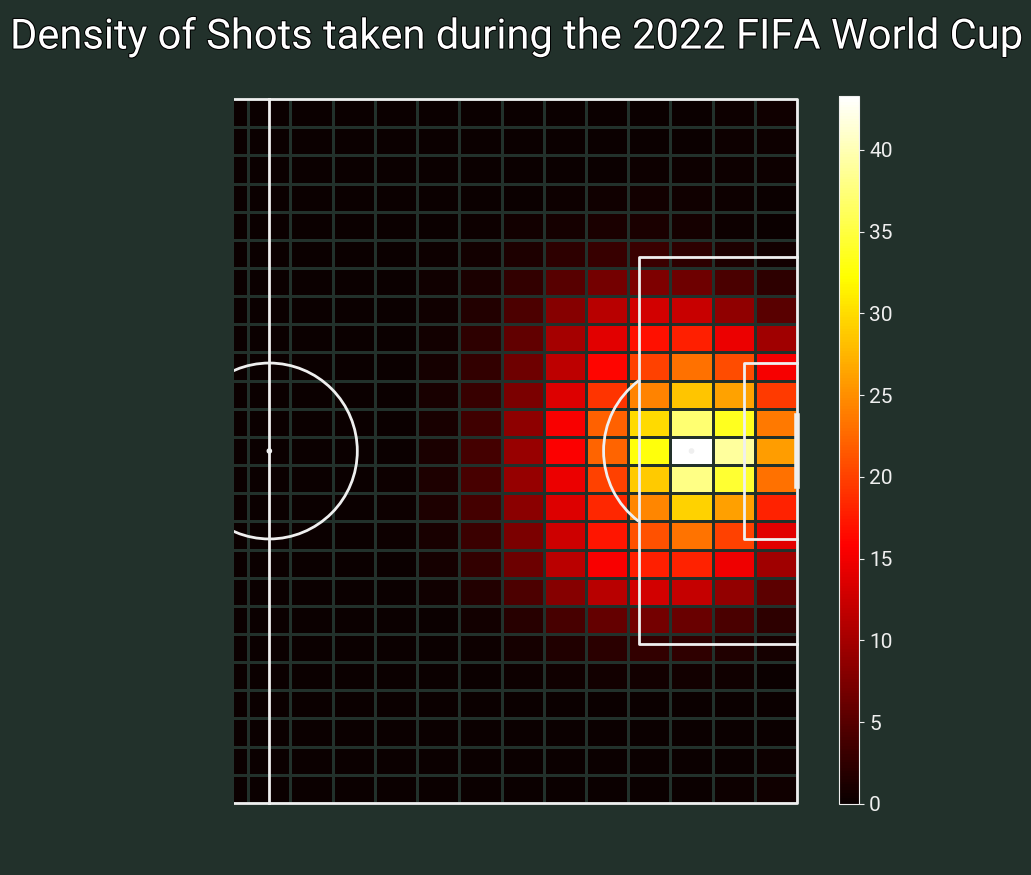

In [35]:
robotto_regular = FontManager()

path_eff = [path_effects.Stroke(linewidth=1.5, foreground='black'),
            path_effects.Normal()]

pearl_earring_cmap = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",
                                                       ['#15242e', '#4393c4'], N=10)


fig, axs = pitch.grid( endnote_height=0.03, endnote_space=0,
                      # leave some space for the colorbar
                      grid_width=0.88, left=0.025,
                      title_height=0.06, title_space=0,
                      # Turn off the endnote/title axis. I usually do this after
                      # I am happy with the chart layout and text placement
                      axis=False,
                      grid_height=0.86)
fig.set_facecolor('#22312b')

# plot heatmap
bin_statistic = pitch.bin_statistic(x_coords, y_coords, statistic='count', bins=(25, 25))
bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)
pcm = pitch.heatmap(bin_statistic, ax=axs['pitch'], cmap='hot', edgecolors='#22312b')

# add cbar
ax_cbar = fig.add_axes((0.915, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
cbar.outline.set_edgecolor('#efefef')
cbar.ax.yaxis.set_tick_params(color='#efefef')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='#efefef')
for label in cbar.ax.get_yticklabels():
    label.set_fontproperties(robotto_regular.prop)
    label.set_fontsize(15)

# endnote and title
ax_title = axs['title'].text(0.5, 0.5, "Density of Shots taken during the 2022 FIFA World Cup", color='white',
                             va='center', ha='center', path_effects=path_eff,
                             fontproperties=robotto_regular.prop, fontsize=30)

In [36]:

def fetch_types(match_id):
    # Fetch match events
    events = sb.events(match_id=match_id)
    
    # Filter for 'Shot' events that resulted in a 'Goal'
    types = events['type']
    
    return types

In [37]:
all_types = pd.DataFrame()

for match_id in match_ids:
    try:
        match_types = fetch_types(match_id)
        all_types = pd.concat([all_types, match_types], ignore_index=True)
    except Exception as e:
        print(f"Failed to process match {match_id}: {e}")

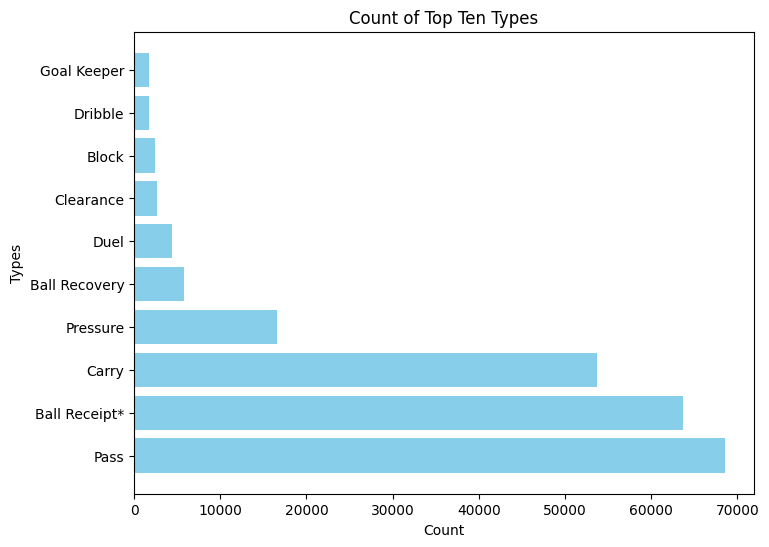

In [38]:
# Get the top ten types
top_ten_types = all_types[0].value_counts().nlargest(10)

plt.figure(figsize=(8, 6))

# Use barh() for horizontal bar chart
plt.barh(top_ten_types.index, top_ten_types, color='skyblue')
plt.xlabel('Count')
plt.ylabel('Types')
plt.title('Count of Top Ten Types')
plt.show()